In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
for dirname, _, filenames in os.walk('../'):
    print(filenames)
    for filename in filenames:
        print(os.path.join(dirname, filename))

[]
[]
['gcp.py']
../lib/kaggle/gcp.py
[]
['enron.csv']
../input/enronemails/enron.csv
['Enron_29_Features.csv']
../input/enron29features/Enron_29_Features.csv
['__notebook_source__.ipynb']
../working/__notebook_source__.ipynb


In [4]:
df = pd.read_csv("../input/enron29features/Enron_29_Features.csv")

This notebook was actually run on kaggle, as K-means clustering was not working on our local machines. Here we are using the Enron 29 Feature Dataset that we created extracting all the stylometric features from all the author emails found in the initial dataset Enron.csv

In [26]:
import re
import string
from sklearn.preprocessing import StandardScaler, LabelEncoder
import nltk
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter 
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
nltk.download("stopwords")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn import preprocessing
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import tensorflow as tf
import string
import re
from collections import Counter

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [27]:
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

In [28]:
df["Folder"].value_counts()

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64

Here we are testing with 5 authors, 4000 emails per author

In [29]:
def text_process(text):
    #Remove Punctuation Marks
    text = text.lower()
    nopunct = ""
    clean_final = []
    for char in text:
        if re.match(r"\w", char) or re.match(r" ", char):
            nopunct += char
        elif re.match(r" ", char):
            nopunct += char
        else:
            nopunct += " "
    for word in nopunct.split():
        if not word in stop_words:
            clean_final.append(word)
    nopunct=" ".join(clean_final)
    return nopunct

In [30]:
df = df[df["Email Length"].notna()]
df = df[df["Author"].notna()]
clean_text = df["Text"].apply(lambda row: text_process(row))
df["Processed Text"] = clean_text

Here we performed text preprocessing, removing all the stop words, and non alphanumeric characters

In [47]:
df["Processed Text"] = proccessed_text

In [48]:
tokenized_text = df["Processed Text"].apply(lambda row: word_tokenize(row))
df["Tokens"] = tokenized_text

In [33]:
def vectorize(list_of_docs, model):

    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

This function takes input of a list of tokens, a trained word2vec model. The function then goes through all the tokens and finds the appropriate word2vec vector and appends the found vector to a list called vectors. To represent the all the word vectors present in the list vectors, we take the average of the vectors and return that to represent the list of tokens passed into the function. If none of the tokens passed in were found in the glove word dictionary a zero vector is returned.

In [34]:
X = df["Tokens"].to_numpy()
y = df["Folder"]
labelencoder = LabelEncoder()
y = labelencoder.fit_transform(y)

Here we are label encoding our target variable Y, which in this case is the folder name or author name of the sent email.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33)

tokenized_docs = X_train["Tokens"]
model = Word2Vec(sentences=tokenized_docs, vector_size=100, workers=1, seed=42)
vectorized_docs = vectorize(tokenized_docs, model=model)

test_tokenized_docs = X_test["Tokens"]
test_vectorized_docs = vectorize(test_tokenized_docs, model=model)

In [36]:
print(X_train.shape)
vect_np = np.asarray(vectorized_docs)
print(vect_np.shape)
print(X_test.shape)
vect_test_np = np.asarray(test_vectorized_docs)
print(vect_test_np.shape)

(13400, 33)
(13400, 100)
(6600, 33)
(6600, 100)


In [37]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            ed = euclidean_distances(points[i].reshape(1, -1), curr_center.reshape(1, -1))
            curr_sse += ed
        sse.append(curr_sse)
    return sse

In [38]:
wss = calculate_WSS(vect_np, 30)

Here we are using WSS, to try to find the optimal number of K

[array([[25705.48926217]]), array([[22482.99491653]]), array([[20079.88305877]]), array([[18792.95656652]]), array([[17686.85691677]]), array([[16980.02833806]]), array([[16477.73525058]]), array([[16006.17961776]]), array([[15553.66548428]]), array([[15115.00972873]]), array([[14814.09882667]]), array([[14500.04011358]]), array([[14224.98211133]]), array([[14154.64197252]]), array([[13950.52470367]]), array([[13722.86383607]]), array([[13484.08703379]]), array([[13348.44935733]]), array([[13200.31707173]]), array([[13171.76303373]]), array([[12903.79969465]]), array([[12758.62243523]]), array([[12604.69778695]]), array([[12560.73533029]]), array([[12345.5356474]]), array([[12222.04736653]]), array([[12123.30823895]]), array([[12035.42471798]]), array([[11917.67434602]]), array([[11776.01771248]])]


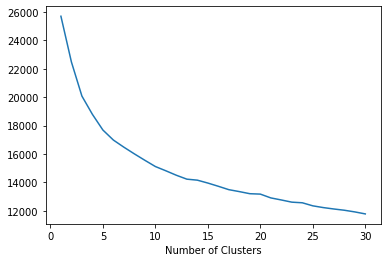

In [53]:
print(wss)
y_axis = []
for _ in wss:
    y_axis.append(_[0][0])
x_axis = list(range(1,31,1))
plt.plot(x_axis, y_axis)
plt.xlabel("Number of Clusters")
plt.show()

However, looking at our graph there is no clear elbow point to choose the right number of clustes

In [40]:
def best_silhouette_score(points, kmax):
    sil = []
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        labels = kmeans.labels_
        score = silhouette_score(points, labels, metric = 'euclidean')
        print(score)
        sil.append(score)
    return sil

In [41]:
sil_scores = best_silhouette_score(vect_np, 30)

0.5888180743121894
0.2304752826883286
0.18849012588403366
0.20174790279773377
0.20725109057613877
0.20432755261091265
0.19187113583776555
0.18252222975284335
0.18617177222219883
0.18215159046511972
0.18678796871997685
0.19003701934450365
0.17282799290157547
0.17525714365752165
0.17658376658017552
0.17181469078787046
0.173550313377515
0.1754199728937396
0.17508257888210088
0.17915222176938547
0.17974893770562142
0.18349248180250766
0.18057324405919467
0.18551568254633644
0.17240363141274592
0.17250963731602864
0.18407021223969358
0.18068327084532151
0.17303101130716814


Let's try to use the Silhoutte Method to find the right number of clusters

[0.5888180743121894, 0.2304752826883286, 0.18849012588403366, 0.20174790279773377, 0.20725109057613877, 0.20432755261091265, 0.19187113583776555, 0.18252222975284335, 0.18617177222219883, 0.18215159046511972, 0.18678796871997685, 0.19003701934450365, 0.17282799290157547, 0.17525714365752165, 0.17658376658017552, 0.17181469078787046, 0.173550313377515, 0.1754199728937396, 0.17508257888210088, 0.17915222176938547, 0.17974893770562142, 0.18349248180250766, 0.18057324405919467, 0.18551568254633644, 0.17240363141274592, 0.17250963731602864, 0.18407021223969358, 0.18068327084532151, 0.17303101130716814]


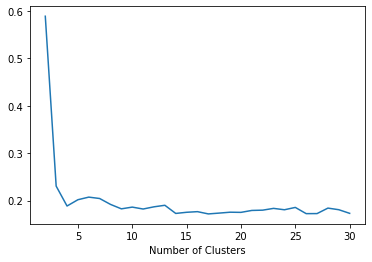

In [54]:
print(sil_scores)
x_axis = list(range(2,31,1))
plt.plot(x_axis, sil_scores)
plt.xlabel("Number of Clusters")
plt.show()

But here also there is no clear peak with which we can choose the Number of Clusters. Let's explore why clustering is not a good option here, with k=30.

In [43]:
kmeans = KMeans(n_clusters = 30).fit(vect_np)
training_labels = kmeans.labels_
testing_labels = kmeans.predict(vect_test_np)

In [44]:
for i in range(0,30,1):
    cluster_df = df.iloc[np.where(training_labels==i)]
    print(cluster_df.shape)
    print("Round {}".format(i))
cluster_df[["Tokens", "Processed Text", "Folder"]]

(794, 33)
Round 0
(544, 33)
Round 1
(255, 33)
Round 2
(482, 33)
Round 3
(916, 33)
Round 4
(500, 33)
Round 5
(653, 33)
Round 6
(747, 33)
Round 7
(59, 33)
Round 8
(318, 33)
Round 9
(325, 33)
Round 10
(242, 33)
Round 11
(197, 33)
Round 12
(266, 33)
Round 13
(205, 33)
Round 14
(223, 33)
Round 15
(381, 33)
Round 16
(190, 33)
Round 17
(891, 33)
Round 18
(98, 33)
Round 19
(332, 33)
Round 20
(236, 33)
Round 21
(438, 33)
Round 22
(352, 33)
Round 23
(824, 33)
Round 24
(336, 33)
Round 25
(1388, 33)
Round 26
(94, 33)
Round 27
(207, 33)
Round 28
(907, 33)
Round 29


,Tokens,Processed Text,Folder
7,[hour],hour,mann-k
37,[yes],yes,mann-k
51,"[know, either, kay]",know either kay,mann-k
54,[speechless],speechless,mann-k
60,"[anything, get, set, booked, 200, otherwise, a...",anything get set booked 200 otherwise availabl...,mann-k
...,...,...,...
13312,"[ces, synthetic, storage, deal, equitable, gas...",ces synthetic storage deal equitable gas compa...,germany-c
13314,"[sure, one, gas, purchase, make, right, 9, 00,...",sure one gas purchase make right 9 00 every mo...,germany-c
13324,"[please, add, tricia, spence, email, working, ...",please add tricia spence email working cgas vo...,germany-c
13375,"[read, call, make, brownies, bring]",read call make brownies bring,germany-c


It looks like the data is getting pretty nicely distributed amongst the 30 clusters. Here clustering is based on the vectors of the emails - which is the average of all the word vectors contained in each email. Let's look at the emails found within the last cluster. As you can see from the Processed Text none of the emails really have anything in common, they show no proper relationship or meaningful insight. 
We believe that by taking the average of all the word vectors and using that to represent the overall email lost a lot of information, and thus clustering using the resulting vector did not result in meaningful clusters.